# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

In [2]:
from sklearn.preprocessing import LabelEncoder

def labelEncoder(data):
    #data = data.fillna(0)
    le = LabelEncoder()
    for m in range(190,230):
        #print(m)
        tmp = data.iloc[:,m].astype(str)
        le.fit(tmp)
        data.iloc[:,m] = le.transform(tmp)        
    return data

In [3]:
# печатаем метрики по кросс-валидации
def get_cv_roc_pr_rc(clf, skf, X, y):
    roc_auc = []
    pr_auc = []
    precision = []
    recall = []
    models = []
    for train, test in skf.split(X, y):
        models.append(clf.fit(X.iloc[train,:], y.iloc[train]))
        y_pred = clf.predict(X.iloc[test,:])
        y_pred_prob = clf.predict_proba(X.iloc[test,:])[:,1]
        roc_auc.append(roc_auc_score(y.iloc[test], y_pred_prob))
        pr_auc.append(average_precision_score(y.iloc[test], y_pred_prob))
        precision.append(precision_score(y.iloc[test], y_pred))
        recall.append(recall_score(y.iloc[test], y_pred))

    print ('ROC-AUC:', np.mean(roc_auc))
    print ('PR-AUC:', np.mean(pr_auc))
    print ('Precission:', np.mean(precision))
    print ('Recall:', np.mean(recall))
    
    return roc_auc, pr_auc, precision, recall, models

In [4]:
train = pd.read_csv('C:/Users/zmey5/GitHub/Stepik/Final_2/DATA/orange_small_churn_train_data.csv', index_col=0)
train.shape

(18299, 231)

In [5]:
test = pd.read_csv('C:/Users/zmey5/GitHub/Stepik/Final_2/DATA/orange_small_churn_test_data.csv')
test.shape

(10000, 231)

In [6]:
train[:-1].head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [7]:
x_data_le = labelEncoder(train.iloc[:,:230])

In [8]:
x_train = x_data_le
y_train = train['labels']

In [9]:
y_train_nan = y_train.drop([18298])
x_train_nan = x_train.drop([18298])
x_train_nan = x_train_nan.fillna(0)
y_train_nan = y_train_nan.fillna(0)

In [10]:
x_train_nan.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,3052.0,0.0,0.0,0.0,0.0,...,0,2580,0,1,2,14,0,29,2,0
1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,0.0,0.0,...,5,256,0,1,0,23,2,2,1,0
2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,0.0,0.0,...,7,1758,0,1,2,7,3,24,1,0
3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,0.0,0.0,...,5,1832,0,1,2,23,2,7,2,0
4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,0.0,0.0,...,5,965,0,1,2,12,2,7,2,0


In [11]:
#выделять отдельно категориальные данные пока не буду, так как они уже преобразованы и пропущенные значения в них отсутствуют. 

labels = train['labels'].fillna(-1)

#выброшу колонки где все элементы пропущены
print(x_data_le.shape)

x_data_col = x_data_le.dropna(axis=1, how='all')

print(x_data_col.shape)

(18299, 230)
(18299, 214)


In [12]:
skf = StratifiedKFold(n_splits=3, random_state=19)

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [0]:
X1 = x_train_nan.copy() 

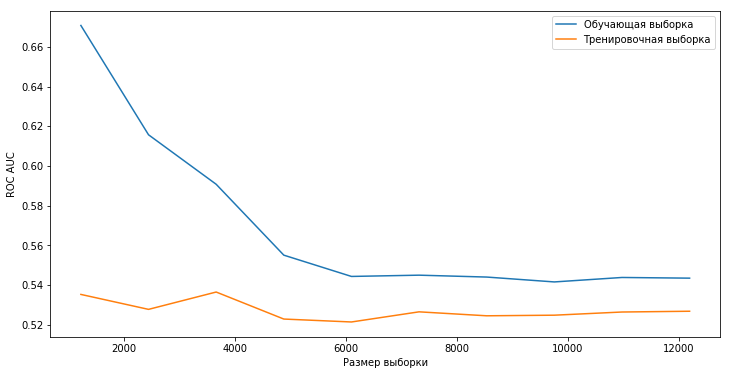

In [0]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), X1, y_train_nan, cv=3, scoring='roc_auc',
                                                       train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label=u"Обучающая выборка")
plt.plot(train_sizes, test_scores.mean(axis=1), label=u"Тренировочная выборка")
plt.xlabel(u'Размер выборки')
plt.ylabel(u'ROC AUC')
plt.legend(loc="best")
plt.show()

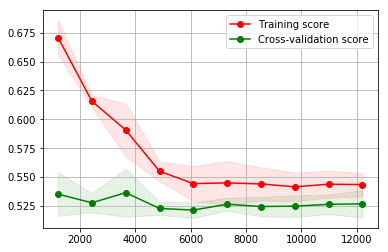

In [0]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")

**Как видно, наибольшее значение достигается при 0,3.**

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [0]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, y_train_nan)

ROC-AUC: 0.5257037812310293
PR-AUC: 0.08598246724986754
Precission: 0.164002664002664
Recall: 0.007262164124909223


In [0]:
w = {-1: 5, 1: 1}
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression(class_weight=w)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, y_train_nan)

ROC-AUC: 0.51444798395294
PR-AUC: 0.08190206876420823
Precission: 0.1803030303030303
Recall: 0.002178649237472767


In [0]:
w = {-1: 1, 1: 5}
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression(class_weight=w)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, y_train_nan)

ROC-AUC: 0.5806604740556883
PR-AUC: 0.10012762246998952
Precission: 0.16566566566566565
Recall: 0.030501089324618733


In [0]:
w = {-1: 5, 1: 25}
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression(class_weight=w)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X1, y_train_nan)

ROC-AUC: 0.5821881756366712
PR-AUC: 0.09994726853860265
Precission: 0.17104637823664373
Recall: 0.03122730573710966


**Хоть последний вариант и больше предпочтительнее, но существенного отличия не получил**

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [0]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

In [0]:
# summarize class distribution
print(Counter(y_train_nan))

Counter({-1.0: 16921, 1.0: 1377})


In [0]:
over_1 = RandomUnderSampler(sampling_strategy=0.5)
X_1, y_1 = over_1.fit_resample(x_train_nan, y_train_nan)
print(Counter(y_1))

Counter({-1.0: 2754, 1.0: 1377})


In [0]:
#Преобразую  все, чтоб не переписывать функцию
X_1 = pd.DataFrame(X_1[:, 1:], index=X_1[:,0])
y_1 = pd.Series(y_1)

In [0]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X_1, y_1)

ROC-AUC: 0.5774749502802815
PR-AUC: 0.39796028774217795
Precission: 0.5162921086101678
Recall: 0.05519244734931009


In [0]:
over_2 = RandomUnderSampler(sampling_strategy=0.25)
X_2, y_2 = over_2.fit_resample(x_train_nan, y_train_nan)
print(Counter(y_2))

Counter({-1.0: 5508, 1.0: 1377})


In [0]:
X_2 = pd.DataFrame(X_2[:, 1:], index=X_2[:,0])
y_2 = pd.Series(y_2)

In [0]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X_2, y_2)

ROC-AUC: 0.5539615184409922
PR-AUC: 0.23210715387047243
Precission: 0.30952380952380953
Recall: 0.013071895424836602


In [0]:
over_3 = RandomUnderSampler(sampling_strategy=0.75)
X_3, y_3 = over_3.fit_resample(x_train_nan, y_train_nan)
print(Counter(y_3))

Counter({-1.0: 1836, 1.0: 1377})


In [0]:
X_3 = pd.DataFrame(X_3[:, 1:], index=X_3[:,0])
y_3 = pd.Series(y_3)

In [0]:
skf = StratifiedKFold(n_splits=3, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X_3, y_3)

ROC-AUC: 0.5809470241739881
PR-AUC: 0.4932725979443644
Precission: 0.5115389316709449
Recall: 0.26870007262164125


Основная метрика (ROC AUC) несколько подросла, если выбрасывать объекты доминирующего класса. Так же растут точность и полнота. В целом, изменение весов и андерсэмплинг незначительно увеличили качество анализа.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [35]:
# ранее пропущенные значения я заменял но 0

# заменим средним значением
X_mean = x_data_col.fillna(x_data_col.mean(axis=0))

In [36]:
X = pd.DataFrame(StandardScaler().fit_transform(X_mean))

In [38]:
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

ROC-AUC: 0.6509728697107485
PR-AUC: 0.12833046748745436
Precission: 0.09801587301587301
Recall: 0.004361001317523057


In [13]:
X_median = x_data_col.fillna(x_data_col.median(axis=0))

In [0]:
X = pd.DataFrame(StandardScaler().fit_transform(X_median))

In [0]:
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, labels)

ROC-AUC: 0.6539110933558742
PR-AUC: 0.1295370015053769
Precission: 0.12333333333333334
Recall: 0.005812911725955204


In [0]:
# испытаю интерполяцию
methods = ['linear', 'quadratic', 'cubic']

In [0]:
for met in methods:
  print("Method: ", met)
  X_pad = x_data_col.interpolate(limit_direction='both', method=met)
  X = pd.DataFrame(StandardScaler().fit_transform(X_pad))
  if X.isna().sum().sum() > 0:
    X = X.fillna(X.median(axis=0))
  skf = StratifiedKFold(n_splits=5, random_state=19)
  clf = LogisticRegression()
  roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, X, labels)

('Method: ', 'linear')
ROC-AUC: 0.5878666342506611
PR-AUC: 0.09906157134657326
Precission: 0.05455548360793342
Recall: 0.012337285902503294
('Method: ', 'quadratic')
ROC-AUC: 0.5795599371820156
PR-AUC: 0.10319998255960909
Precission: 0.13672810406244143
Recall: 0.031926218708827406
('Method: ', 'cubic')
ROC-AUC: 0.5759702958086806
PR-AUC: 0.09934832220359424
Precission: 0.1367431752625056
Recall: 0.0333965744400527


**Как видно, наиболее эффективно - использование медианы для заполнения NaN значений**

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [14]:
from sklearn.preprocessing import OneHotEncoder

def oneHotEncoder(data):
    data = data.fillna(0)
    ohe = OneHotEncoder(sparse = False)
    df = pd.DataFrame()
    for m in range(190,230):
        #print(m)
        tmp = data.iloc[:,m].astype(str)
        ohe.fit(tmp.values.reshape(-1,1))
        #data.iloc[:,m] = ohe.transform(tmp.values.reshape(-1,1))
        if m == 190:
          df = pd.DataFrame(ohe.transform(tmp.values.reshape(-1,1)))
          #print(df.shape)
        else:
          df_2 = pd.DataFrame(ohe.transform(tmp.values.reshape(-1,1)))
          df = pd.concat([df, df_2], axis=1)
          #print(df.shape)
        #df = pd.concat([df, ohe.transform(tmp.values.reshape(-1,1))])
               
    return df

In [15]:
x_data_ohe = oneHotEncoder(train.iloc[:,:230])

In [22]:
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_data_ohe, labels)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC: 0.6380916345933023
PR-AUC: 0.13922012167518033
Precission: 0.2490619500825188
Recall: 0.03557575757575757


In [18]:
x_median_ohe = pd.concat([X_median, x_data_ohe], axis=1)

In [55]:
skf = StratifiedKFold(n_splits=5, random_state=19)
clf = LogisticRegression()
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_median_ohe, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteratio

ROC-AUC: 0.5972578063727637
PR-AUC: 0.10658598084138218
Precission: 0.11666666666666665
Recall: 0.0014519104084321475


**Рассмотрение только категориальныйх признаков без числовых и использование oneHotEncoder показало лучший результат, чем LabelEncoder**

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [16]:
from sklearn.feature_selection import SelectKBest

In [21]:
clf = LogisticRegression()

In [63]:
best_50 = SelectKBest(k=50).fit(x_train_nan,y_train_nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  7  14  19  30  31  38  41  47  51  54  66  78 140 166 168 174 184 208
 229] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [65]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_train_nan.loc[:, best_50.get_support()], y_train_nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC: 0.5318031420688987
PR-AUC: 0.08648734800782776
Precission: 0.2888888888888889
Recall: 0.002178649237472767


In [66]:
best_100 = SelectKBest(k=100).fit(x_train_nan,y_train_nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  7  14  19  30  31  38  41  47  51  54  66  78 140 166 168 174 184 208
 229] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [67]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_train_nan.loc[:, best_100.get_support()], y_train_nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

ROC-AUC: 0.5148468217828022
PR-AUC: 0.08328819842893723
Precission: 0.18974358974358974
Recall: 0.007988380537400147


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [68]:
best_150 = SelectKBest(k=150).fit(x_train_nan,y_train_nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  7  14  19  30  31  38  41  47  51  54  66  78 140 166 168 174 184 208
 229] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [69]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_train_nan.loc[:, best_150.get_support()], y_train_nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

ROC-AUC: 0.517520711428562
PR-AUC: 0.08417168060483234
Precission: 0.14641975308641975
Recall: 0.007262164124909223


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
best_100 = SelectKBest(k=100).fit(x_median_ohe, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [   56   106   192   213 18418 40662] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [26]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_median_ohe.ix[:, best_100.get_support()], labels)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC: 0.6531176383319662
PR-AUC: 0.13443228358131154
Precission: 0.27777777777777773
Recall: 0.0014524328249818448


In [27]:
best_500 = SelectKBest(k=500).fit(x_median_ohe, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [   56   106   192   213 18418 40662] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [28]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_median_ohe.ix[:, best_500.get_support()], labels)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC: 0.6521580499327747
PR-AUC: 0.1338745376683056
Precission: 0.27777777777777773
Recall: 0.0014524328249818448


In [67]:
best_1000 = SelectKBest(k=1000).fit(x_median_ohe, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [   56   106   192   213 18418 40662] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [68]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_median_ohe.ix[:, best_1000.get_support()], labels)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-pack

ROC-AUC: 0.651397310625401
PR-AUC: 0.1349981522805935
Precission: 0.3
Recall: 0.0014519104084321475


In [19]:
best_250 = SelectKBest(k=250).fit(x_median_ohe, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [   56   106   192   213 18418 40662] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [22]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_median_ohe.ix[:, best_250.get_support()], labels)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC: 0.6523600803538121
PR-AUC: 0.13385769058026564
Precission: 0.27777777777777773
Recall: 0.0014524328249818448


In [23]:
best_300 = SelectKBest(k=300).fit(x_median_ohe, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [   56   106   192   213 18418 40662] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [24]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(clf, skf, x_median_ohe.ix[:, best_300.get_support()], labels)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC: 0.6522355579932321
PR-AUC: 0.13387169230134863
Precission: 0.27777777777777773
Recall: 0.0014524328249818448


In [17]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test,y_train,y_test=train_test_split(x_train_nan,y_train_nan, test_size=0.3, random_state=19)

In [18]:
lasso = linear_model.Lasso()
lasso.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9810663244097668, tolerance: 0.3569173953778881
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

In [20]:
print ("training score:", train_score )
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

training score: 0.014037557055804784
test score:  0.00488569009059614
number of features used:  64


In [39]:
y_pred_lasso = lasso.predict(X_test)

In [43]:
print ('ROC-AUC:', roc_auc_score(y_test, y_pred_lasso))
print ('PR-AUC:', average_precision_score(y_test, y_pred_lasso))

ROC-AUC: 0.596344597100762
PR-AUC: 0.10332261070802358


In [21]:
lasso001 = linear_model.Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000000.0,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

In [23]:
print ("training score for alpha=0.01:", train_score001) 
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

training score for alpha=0.01: 0.025032830622218838
test score for alpha =0.01:  0.01118659976797165
number of features used: for alpha =0.01: 104


In [44]:
y_pred_lasso001 = lasso001.predict(X_test)

In [45]:
print ('ROC-AUC:', roc_auc_score(y_test, y_pred_lasso001))
print ('PR-AUC:', average_precision_score(y_test, y_pred_lasso001))

ROC-AUC: 0.6320157962962254
PR-AUC: 0.1125974336345104


In [25]:
lasso00001 = linear_model.Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000000.0,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

In [27]:
print ("training score for alpha=0.0001:", train_score00001) 
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)

training score for alpha=0.0001: 0.032628836286029084
test score for alpha =0.0001:  -0.0012179628743678172
number of features used: for alpha =0.0001: 184


In [46]:
y_pred_lasso00001 = lasso00001.predict(X_test)

In [47]:
print ('ROC-AUC:', roc_auc_score(y_test, y_pred_lasso00001))
print ('PR-AUC:', average_precision_score(y_test, y_pred_lasso00001))

ROC-AUC: 0.6387347667646845
PR-AUC: 0.11481446515130467


In [53]:
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)

In [54]:
print ("LR training score:", lr_train_score )
print ("LR test score: ", lr_test_score)

LR training score: 0.03283992121103474
LR test score:  -0.002766210320229723


In [55]:
y_pred_lr = lr.predict(X_test)

In [56]:
print ('ROC-AUC:', roc_auc_score(y_test, y_pred_lr))
print ('PR-AUC:', average_precision_score(y_test, y_pred_lr))

ROC-AUC: 0.6409683691691171
PR-AUC: 0.11535224063384648


**В случае использования преобразования переменных при пощи LabelEncoder и последующего поиска количества значимых признаков при помощи SelectKBest - 50 признаков оптимально, потом пошло на спад. Если же использовать категориальные переменные, преобразованные OneHotEncoder, то точность значительно возрастает, но и в этом случае на малом количестве данных. Значение параметра регуляризации по умолчанию в регрессии лассо (заданное α) равно 1 и при этом из 240 признаков в наборе данных используются только 64 признака. Дальнейшее уменьшение альфа привело к использованию 184 признаков и приблизило значение к значению линейной регрессии.**

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [35]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [30]:
#оставлю только признаки показавшие наилучшие значение
x_best = x_median_ohe.loc[:, best_100.get_support()]

In [47]:
#создам новые имена для колонок или XGB отказывается работать
new_col_name = []
for i in range(0, 100):
    name = "Var_dumn " + str(i)
    #print("Var_dumn ",i)
    new_col_name.append(name)

x_best.columns = new_col_name

In [49]:
# попробуем xgboost
bst = xgb.XGBClassifier(n_estimators=100)
params = {'max_depth': [2, 3, 4],
          'learning_rate': [0.05, 0.1],
          'subsample': [0.8, 1.0]}

xgb_grid = GridSearchCV(bst, params, scoring = 'roc_auc', cv=3, n_jobs=-1, verbose=1)

xgb_grid.fit(x_best, labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   46.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3, 4],
                         'subsample': [0.8, 1.0]},
             pre_dispatch='2*n_jobs', r

In [57]:
df_result = pd.DataFrame(xgb_grid.cv_results_)
df_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.638323,0.010204,0.068816,0.004953,0.05,2,0.8,"{'learning_rate': 0.05, 'max_depth': 2, 'subsa...",0.712911,0.728048,0.717844,0.719601,0.006303,11
1,6.495020,0.018031,0.059840,0.000814,0.05,2,1,"{'learning_rate': 0.05, 'max_depth': 2, 'subsa...",0.713106,0.726714,0.716989,0.718937,0.005723,12
2,8.431900,0.047365,0.070146,0.000470,0.05,3,0.8,"{'learning_rate': 0.05, 'max_depth': 3, 'subsa...",0.716625,0.732577,0.723163,0.724122,0.006548,4
3,8.278614,0.084565,0.067819,0.001629,0.05,3,1,"{'learning_rate': 0.05, 'max_depth': 3, 'subsa...",0.712027,0.729632,0.721996,0.721218,0.007209,9
4,10.342421,0.063717,0.073470,0.001244,0.05,4,0.8,"{'learning_rate': 0.05, 'max_depth': 4, 'subsa...",0.717886,0.735380,0.726180,0.726482,0.007145,1


In [58]:
# оптимальные параметры
xgb_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8}

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

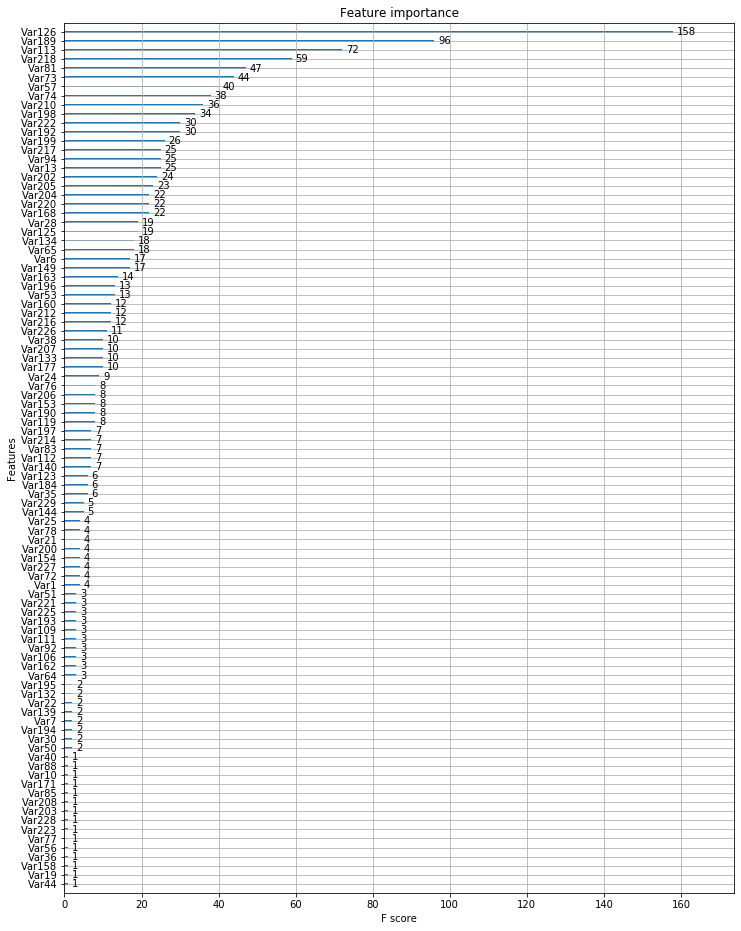

In [64]:
fig, ax = plt.subplots(figsize=(12, 16))
xgb.plot_importance(xgb_grid.best_estimator_, ax=ax)
plt.show()

**По оценке xgb из 10 признаков 7 являются числовыми**

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [68]:
import seaborn as sns

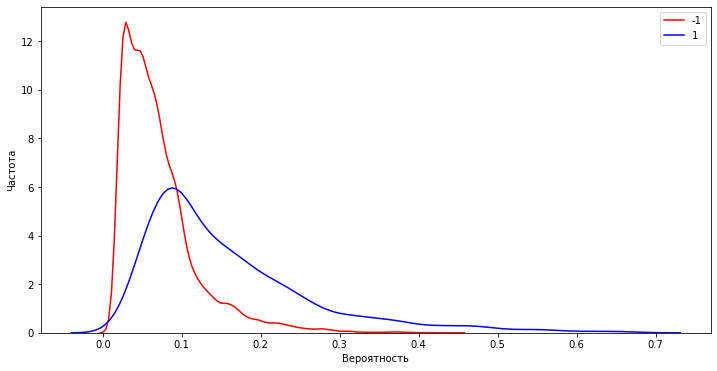

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))

pred = pd.Series(xgb_grid.best_estimator_.predict_proba(x_data_le)[:,1])
# гистограмма отклонений от истинных значений
sns.kdeplot(pred[labels == -1], color = 'r', ax=ax, label=-1)
sns.kdeplot(pred[labels == 1], color = 'b', ax=ax, label=1)
plt.ylabel(u'Частота')
plt.xlabel(u'Вероятность')
plt.show()

Большинству объектов отрицательного класса предсказываются маленькие вероятности (до 0.2). Сравим средние значения по важным (по мнению xgboost) признакам для явно ошибочных предсказаний и для более-менее правдоподобных. Сравним разницу:

In [73]:
idx_low = pred[(pred < 0.05) & (labels == -1)].index
idx_high = pred[(pred > 0.3) & (labels == 1)].index

means_low = x_data_le.loc[idx_low, (xgb_grid.best_estimator_.feature_importances_ != 0).tolist()].mean()
means_high = x_data_le.loc[idx_high, (xgb_grid.best_estimator_.feature_importances_ != 0).tolist()].mean()

diff = pd.DataFrame(dict(means_low = means_low, means_high = means_high))
diff['abs_diff'] = abs(diff['means_high'] - diff['means_low'])
diff.sort_values('abs_diff', ascending=False)[:15]

,means_low,means_high,abs_diff
Var153,6.013729e+06,7.416875e+06,1.403146e+06
Var177,4.713975e+05,1.489719e+06,1.018322e+06
Var133,2.232702e+06,2.958541e+06,7.258385e+05
Var113,-3.258728e+05,3.526569e+05,6.785296e+05
Var53,6.478113e+05,1.209887e+06,5.620754e+05
Var38,2.476867e+06,2.977972e+06,5.011054e+05
Var10,3.043220e+05,7.776000e+05,4.732780e+05
Var139,1.451461e+05,5.944220e+05,4.492759e+05
Var154,1.636658e+06,2.069457e+06,4.327989e+05
Var76,1.466516e+06,1.734569e+06,2.680530e+05


**Признаки не достаточно хороши**

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

**Не хватило мощности компьютера, но я бы выбрал:**
    * заполнение NaN при помрщи median
    * преобразование категориальных признаков при помощи oneHotEncoder
    * для отбора признаков SelectKBest 
    * важность признаков XGBClassifier

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

**Необходимо провести больше работты с признаками и попробовать их объеденить**